
# Step 1 — Random Walk Intuition (Brownian Motion warm‑up)

**Goal:** build a clear mental model of Brownian motion starting from a simple 1‑D random walk: a point that moves right or left by one small step at each tick of time, at random.

What you will do in this notebook:
- Simulate a basic random walk (±1 steps).
- See how the **spread grows with time**.
- Look at the **distribution at a fixed time**.
- Check that **successive steps are independent** (no memory).
- Connect this to the idea of Brownian motion as a “limit” of finer and finer steps.


In [1]:

# Setup
import numpy as np
import matplotlib.pyplot as plt

def random_walk(steps=1000, seed=None):
    """Return positions for a 1-D random walk with ±1 steps.
    Shape: (steps+1,). Position starts at 0.
    """
    rng = np.random.default_rng(seed)
    # Draw ±1 with equal probability
    step_vals = rng.choice([-1, 1], size=steps)
    pos = np.empty(steps + 1, dtype=int)
    pos[0] = 0
    pos[1:] = np.cumsum(step_vals)
    return pos



## Experiment 1 — Visualize several random walks

**What to expect:** zigzags with no obvious trend, centered roughly around 0. As time grows, paths spread out.


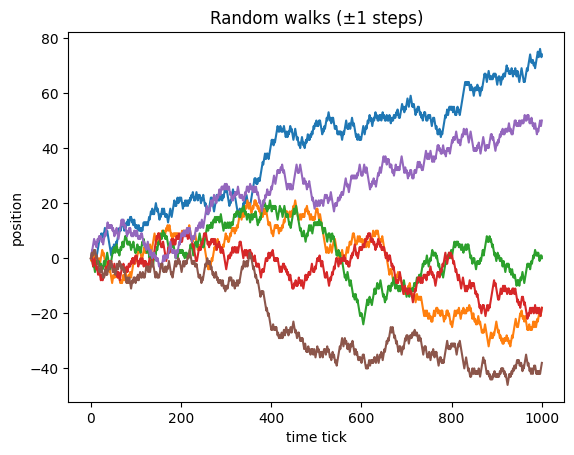

In [2]:

T = 1000  # number of time ticks
paths = 6 # how many walks to visualize

plt.figure()
for k in range(paths):
    pos = random_walk(T, seed=k)
    plt.plot(range(T+1), pos)
plt.xlabel("time tick")
plt.ylabel("position")
plt.title("Random walks (±1 steps)")
plt.show()



## Experiment 2 — Distribution at a fixed time

Pick a specific time (e.g., tick 500) and look at all the positions we get across many independent walks.

**Key idea:** At time *t*, positions are typically near 0, and extreme values are rarer. As *t* increases, the spread grows.


### Proof: Mean and variance of a simple random walk

**Setup.** Steps $X_1,X_2,\dots$ are i.i.d. with $\mathbb{E}[X_k]=0$ and $\operatorname{Var}(X_k)=\sigma_X^2$.
Define $S_n=\sum_{k=1}^n X_k$ with $S_0=0$.

**Mean**

$$
\mathbb{E}[S_n]=\sum_{k=1}^n \mathbb{E}[X_k]=n\cdot 0=0.
$$

**Variance (using independence)**

$$
\operatorname{Var}(S_n)
=\operatorname{Var}\!\left(\sum_{k=1}^n X_k\right)
=\sum_{k=1}^n \operatorname{Var}(X_k)
= n\,\sigma_X^2.
$$

For symmetric $\pm 1$ steps, $\sigma_X^2=1$ so $\operatorname{Var}(S_n)=n$.

Mean at tick 500: -0.211
Variance at tick 500: 526.112


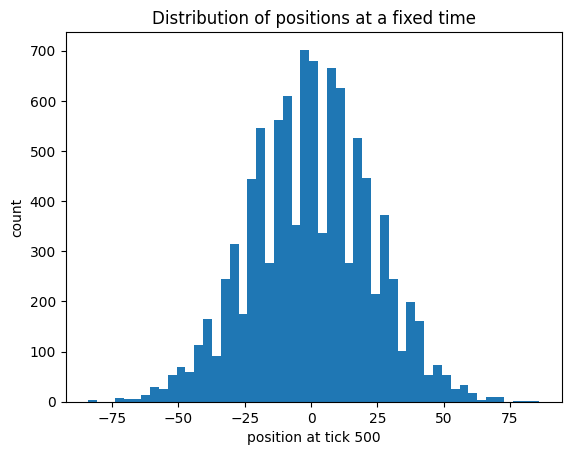

In [3]:

T = 1000
tick = 500
num_paths = 10000

# Collect positions at the chosen tick across many walks
samples = np.empty(num_paths, dtype=int)
for k in range(num_paths):
    pos = random_walk(T, seed=k)
    samples[k] = pos[tick]

# Summary stats and histogram
print(f"Mean at tick {tick}: {samples.mean():.3f}")
print(f"Variance at tick {tick}: {samples.var(ddof=1):.3f}")

plt.figure()
plt.hist(samples, bins=51)
plt.xlabel(f"position at tick {tick}")
plt.ylabel("count")
plt.title("Distribution of positions at a fixed time")
plt.show()



## Experiment 3 — How spread grows with time

Compute the sample variance of positions across many walks at different times.  
**Claim:** the variance grows roughly **linearly** with time.


### Proof: Variance grows like time ($\Delta t$) for Brownian-style scaling

Use small, frequent steps:

$$
\Delta W_k=\sqrt{\Delta t}\,Z_k,\qquad Z_k\sim\mathcal{N}(0,1)\ \text{i.i.d.}
$$

Define $W_n=\sum_{k=1}^n \Delta W_k$ at time $t_n=n\,\Delta t$.

* Each increment has variance

$$
\operatorname{Var}(\Delta W_k)
=\operatorname{Var}\!\big(\sqrt{\Delta t}\,Z_k\big)
=\Delta t\cdot \operatorname{Var}(Z_k)
=\Delta t.
$$

* By independence,

$$
\operatorname{Var}(W_n)
=\sum_{k=1}^n \operatorname{Var}(\Delta W_k)
=\sum_{k=1}^n \Delta t
= n\,\Delta t
= t_n.
$$

**Conclusion.** At fixed time $t$, $\operatorname{Var}(W_t)=t$ and, for a small interval $\Delta t$,

$$
\operatorname{Var}(W_{t+\Delta t}-W_t)=\Delta t.
$$

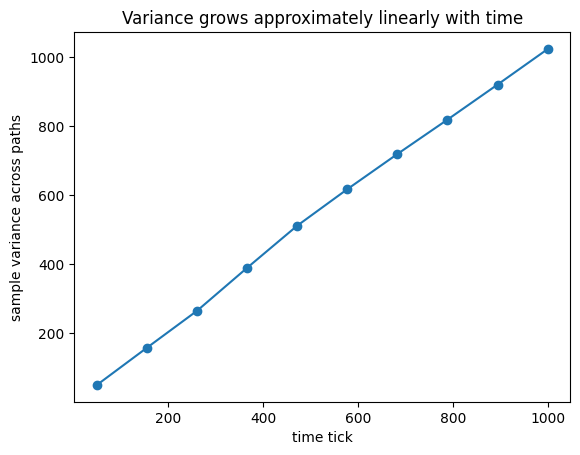

Linear fit: variance ≈ 1.031 * time + 6.909


In [4]:

T = 1000
num_paths = 5000

# Generate many walks once for efficiency
walks = np.empty((T+1, num_paths), dtype=int)
for k in range(num_paths):
    walks[:, k] = random_walk(T, seed=k)

# Estimate variance across paths for a grid of times
check_ticks = np.linspace(50, T, 10, dtype=int)  # avoid very small times at start
vars_est = []
for t in check_ticks:
    vars_est.append(walks[t].var(ddof=1))

plt.figure()
plt.plot(check_ticks, vars_est, marker="o")
plt.xlabel("time tick")
plt.ylabel("sample variance across paths")
plt.title("Variance grows approximately linearly with time")
plt.show()

# Quick and dirty linear fit (least squares) to show linear trend
A = np.vstack([check_ticks, np.ones_like(check_ticks)]).T
m, b = np.linalg.lstsq(A, np.array(vars_est), rcond=None)[0]
print(f"Linear fit: variance ≈ {m:.3f} * time + {b:.3f}")



## Experiment 4 — Independence of steps (no memory)

Build one long walk, extract its steps (±1), and compute the **lag-1 autocorrelation**.  
Under independence, this should be close to 0.


### Proof: Independence of increments

With
$$
W_n = \sum_{k=1}^n \sqrt{\Delta t}\, Z_k,
$$
increments on disjoint intervals use disjoint sets of i.i.d. $Z_k$ and are therefore independent.  

For $0 \leq s < t < u < v$ on the grid,
$$
W_t - W_s = \sum_{k = s/\Delta t + 1}^{t/\Delta t} \sqrt{\Delta t}\, Z_k,
\qquad
W_v - W_u = \sum_{k = u/\Delta t + 1}^{v/\Delta t} \sqrt{\Delta t}\, Z_k,
$$
which involve non-overlapping indices, hence independence.  

In the limit, Brownian motion has **independent increments**.


In [5]:

# Build steps explicitly
rng = np.random.default_rng(123)
steps = rng.choice([-1, 1], size=100_000)
# lag-1 autocorrelation: corr(steps[:-1], steps[1:])
x = steps[:-1].astype(float)
y = steps[1:].astype(float)
corr = np.corrcoef(x, y)[0, 1]
print(f"Lag-1 autocorrelation ≈ {corr:.4f} (should be near 0)")


Lag-1 autocorrelation ≈ 0.0031 (should be near 0)



## Concept bridge — From random walk to Brownian motion

If you make the time steps **smaller** and the moves **smaller** (scaled like the square‑root of the time step), and you look at the curve in continuous time, the discrete random walk converges to **Brownian motion**.

- Brownian motion starts at 0.
- Its average position at any fixed time is 0.
- Its spread (variance) at time *t* grows proportionally to *t*.
- It has **independent** increments: what happens next does not depend on the past.

We will use this continuous‑time object as the “noise” building block in finance later.


### Distribution at a fixed time (Normal / CLT)

At $t_n=n\,\Delta t$,

$$
W_n=\sum_{k=1}^n \sqrt{\Delta t}\,Z_k
=\sqrt{\Delta t}\sum_{k=1}^n Z_k
\sim \mathcal{N}(0,\,n\Delta t)=\mathcal{N}(0,\,t_n).
$$

If steps are generic mean-zero, finite-variance (not necessarily normal), the **CLT** implies the standardized sum is approximately normal, explaining the bell-shape in histograms.

---

### Scaling / “spread grows like $\sqrt{t}$”

Since $\operatorname{Var}(W_t)=t$, the standard deviation is $\sqrt{t}$.
Brownian motion is self-similar:

$$
W_{ct}\ \stackrel{d}{=}\ \sqrt{c}\,W_t,
$$

i.e., same distributional shape, scaled by $\sqrt{c}$.

---

### (Optional) Quadratic variation intuition

Partition $[0,t]$ into $n$ pieces of size $\Delta t=t/n$. With $\Delta W_k\sim\mathcal{N}(0,\Delta t)$,

$$
\mathbb{E}\!\left[(\Delta W_k)^2\right]=\Delta t,\qquad
\mathbb{E}\!\left[\sum_{k=1}^n (\Delta W_k)^2\right]=\sum_{k=1}^n \Delta t=t.
$$

One can show $\sum_{k=1}^n (\Delta W_k)^2 \to t$ in probability: Brownian quadratic variation $[W]_t=t$.


## Try it yourself

1. Change the number of paths and ticks in *Experiment 1*. What happens to the envelope of the trajectories?
2. In *Experiment 2*, try different fixed times (100, 700, 1000). How do the mean and variance change?
3. In *Experiment 3*, increase `num_paths` to stabilize the variance curve. Does the fitted slope get closer to 1?
4. Replace ±1 steps by ±2 (or a mix like −2, −1, +1, +2). How does that change the spread?
5. Bonus: compute the **lag-5** autocorrelation of steps in *Experiment 4* and check it is also near 0.


## Answers / Expected outcomes (for the exercises)

1. **More paths & ticks.** More paths = denser fan, still centered near 0. Longer time = wider envelope; std-dev grows like $\sqrt{t}$ (variance $\sim t$).

2. **Different fixed times.** Mean $\approx 0$. Variance at time $t$ $\approx t$ (if a tick is one time unit). From 100 to 700 ticks → variance $\sim 7\times$ larger.

3. **Stabilize variance curve.** Increasing `num_paths` reduces sampling noise; the linear-fit slope $\to 1$ for $\pm 1$ steps (or $\to a^2$ for $\pm a$ steps since $\operatorname{Var}(X_k)=a^2$).

4. **Change step sizes.** Spread scales with step variance. For $\pm 2$, $\operatorname{Var}(X_k)=4$ → $\operatorname{Var}(S_n)\approx 4n$, std-dev $\approx 2\sqrt{n}$.

5. **Lag-5 autocorrelation of steps.** For i.i.d. steps, any finite-lag autocorrelation $\approx 0$ (converges to 0 as sample length increases).